In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import binned_statistic
import scipy.optimize as opt
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
plt.rcParams['font.size'] = 15
from mycolorpy import colorlist as mcp
from Fhcalc import *
from ErrMask import *

# Characterize how leakage is sensitive to different error masks.

## Fix noise in k space

- ### Fix the filter width $dk=2$ and increase the inner radius $k_{in}$.

In [3]:

### verification: Nscreen2048; Ninterp1024; D15.0; sigma1.0; trunc4.0
 
# initialize parameters
N_screen = 2048 # 8192 for figures in the paper; this only changes the leakage amplitude, irrelevant to the pattern we're studying 
N_theta = 1024  # 1024
D = 15.0
sigma = 1.0
maxdeg = 5.0
trunc = 'y'
option ='amp' # or 'phase'
amp = 0.1 

#k_in = np.array([1, 10]) # test
k_in = np.arange(1,72,3)
radius = 2 # width of the annulus, dk
leak = np.zeros(len(k_in)) 
noise_norm = np.zeros_like(leak) # normalized noise level in k space

def rms(x):
    return np.sqrt(np.mean(x**2))

# unperturbed perfect gaussian create E screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
    InCircle(screen, center, 2.5)
ScreenFFT(screen)

# interpolation in sky intensity [rad] (unperturbed beam)
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in ell space
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

for i in range(len(k_in)):
    kin = k_in[i] # for each noise filter 
    kout = kin + radius

    print('error amp =', amp, 'k_in =', kin, 'k_out =', kout)
    
    # perturbed E screen
    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.5)

    if option=='phase':
        emap_E = filter_annulus_phase(screen1, amp, kin, kout)
    elif option=='amp':
        emap_E = filter_annulus_amp(screen1, amp, kin, kout)
    else: print('Choose phase or amplitude errors')

    ScreenFFT(screen1)

    # interpolate the perturbed beam 
    theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
    II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
    II1 = II1 * (np.sum(II0)/np.sum(II1)) ## normalize the perturbed beam 
    # shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
    theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

    # FT of sky intensity
    I_diff = II1 - II0 # take the difference in theta space (sky)
    fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
    fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space

    # average (FT of II0)^2 radially 
    bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
    l_flatten = l.flatten()
    fft_numerical0 = fft_I0.flatten()
    #fft_numerical1 = fft_I1.flatten()
    fft_numerical_diff = fft_Idiff.flatten()
    bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
    #bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
    bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
    l_vec = bin_edges[0:-1] # ell 1D vector

    beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
    #error[i] = np.mean(beam_diff_rela[1:3]) ## maxdeg=3.0
    #error[i] = np.mean(beam_diff_rela[4]) ## maxdeg=10.0
    leak[i] = np.mean(beam_diff_rela[(l_vec>=49)&(l_vec<=251)])**2 # average the beam difference over 50<l<250
#     print('leakage (error^2) = {}'.format(leak[i]))

    # Calculates the noise level in fourier space (V^2/Hz)
    emap_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(emap_E))) # scaled error map in fourier space
    norm_fft = np.abs(emap_fft**2)/screen1['dk']**2/screen1['N']**4 # V^2/Hz^2
    idx = np.where((screen1['kap']<kout) & (screen1['kap']>kin)) # inside the filter
    avg_fft = np.mean(norm_fft[idx]) # V^2/Hz^2
    total_Vf = np.sum(norm_fft)*screen1['dk']**2
    rms_sq = np.abs(rms(emap_E)**2)
#     print('V^2/Hz^2 = ',total_Vf)
#     print('RMS^2 = ', rms_sq)
    noise_norm[i] = avg_fft

print('Done')

error amp = 0.1 k_in = 1 k_out = 3
error amp = 0.1 k_in = 4 k_out = 6
error amp = 0.1 k_in = 7 k_out = 9
error amp = 0.1 k_in = 10 k_out = 12
error amp = 0.1 k_in = 13 k_out = 15
error amp = 0.1 k_in = 16 k_out = 18
error amp = 0.1 k_in = 19 k_out = 21
error amp = 0.1 k_in = 22 k_out = 24
error amp = 0.1 k_in = 25 k_out = 27
error amp = 0.1 k_in = 28 k_out = 30
error amp = 0.1 k_in = 31 k_out = 33
error amp = 0.1 k_in = 34 k_out = 36
error amp = 0.1 k_in = 37 k_out = 39
error amp = 0.1 k_in = 40 k_out = 42
error amp = 0.1 k_in = 43 k_out = 45
error amp = 0.1 k_in = 46 k_out = 48
error amp = 0.1 k_in = 49 k_out = 51
error amp = 0.1 k_in = 52 k_out = 54
error amp = 0.1 k_in = 55 k_out = 57
error amp = 0.1 k_in = 58 k_out = 60
error amp = 0.1 k_in = 61 k_out = 63
error amp = 0.1 k_in = 64 k_out = 66
error amp = 0.1 k_in = 67 k_out = 69
error amp = 0.1 k_in = 70 k_out = 72
Done


Text(0.9, 5.78616804489094e-08, '0.014')

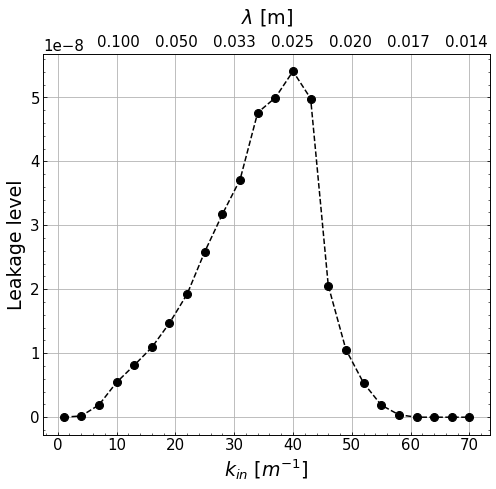

In [6]:
fig = plt.figure(figsize=(8,7))
x = 1/k_in # spacial scale corresponding to k_in

ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
ax2.set_xticks([])
ax1.plot(k_in,leak,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$k_{in}$ [$m^{-1}$]', fontsize=19)
ax1.grid()

ax2.xaxis.set_label_coords(.5, 1.08)
ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
plt.text(0.12, leak.max()*1.07, '0.100')
plt.text(0.25, leak.max()*1.07, '0.050')
plt.text(0.38, leak.max()*1.07, '0.033')
plt.text(0.51, leak.max()*1.07, '0.025')
plt.text(0.64, leak.max()*1.07, '0.020')
plt.text(0.77, leak.max()*1.07, '0.017')
plt.text(0.9, leak.max()*1.07, '0.014')



- ### Fix the inner radius $k_{in}$ and increase the filter width $dk$.

In [11]:
kin = 0
#k_in = np.array([1, 10]) # test
dk = np.arange(1,80,4)
leak= np.zeros(len(dk)) #leakage
noise_norm = np.zeros_like(leak)

def rms(x):
    return np.sqrt(np.mean(x**2))

# unperturbed perfect gaussian create E screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
    InCircle(screen, center, 2.5)
ScreenFFT(screen)

# interpolation in sky intensity [rad] (unperturbed beam)
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in ell space
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

for i in range(len(dk)):
    kout = kin + dk[i]

    print('error amp =', amp, 'k_in =', kin, 'k_out =', kout)
    
    # perturbed E screen
    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.5)

    if option=='phase':
        emap_E = filter_annulus_phase(screen1, amp, kin, kout)
    elif option=='amp':
        emap_E = filter_annulus_amp(screen1, amp, kin, kout)
    else: print('Choose phase or amplitude errors')

    ScreenFFT(screen1)

    # interpolate the perturbed beam 
    theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
    II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
    II1 = II1 * (np.sum(II0)/np.sum(II1)) ## normalize the perturbed beam 
    # shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
    theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

    # FT of sky intensity
    I_diff = II1 - II0 # take the difference in theta space (sky)
    fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
    fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space

    # average (FT of II0)^2 radially 
    bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
    l_flatten = l.flatten()
    fft_numerical0 = fft_I0.flatten()
    #fft_numerical1 = fft_I1.flatten()
    fft_numerical_diff = fft_Idiff.flatten()
    bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
    #bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
    bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
    l_vec = bin_edges[0:-1] # ell 1D vector

    beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
    #error[i] = np.mean(beam_diff_rela[1:3]) ## maxdeg=3.0
    #error[i] = np.mean(beam_diff_rela[4]) ## maxdeg=10.0
    leak[i] = np.mean(beam_diff_rela[(l_vec>=49)&(l_vec<=251)])**2 # average the beam difference over 50<l<250
#     print('leakage (error^2) = {}'.format(leak[i]))

    # Calculates the noise level in fourier space (V^2/Hz)
    emap_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(emap_E))) # scaled error map in fourier space
    norm_fft = np.abs(emap_fft**2)/screen1['dk']**2/screen1['N']**4 # V^2/Hz^2
    idx = np.where((screen1['kap']<kout) & (screen1['kap']>kin)) # inside the filter
    avg_fft = np.mean(norm_fft[idx]) # V^2/Hz^2
    total_Vf = np.sum(norm_fft)*screen1['dk']**2
    rms_sq = np.abs(rms(emap_E)**2)
#     print('V^2/Hz^2 = ',total_Vf)
#     print('RMS^2 = ', rms_sq)
    noise_norm[i] = avg_fft

print('Done')

error amp = 0.1 k_in = 0 k_out = 1
error amp = 0.1 k_in = 0 k_out = 5
error amp = 0.1 k_in = 0 k_out = 9
error amp = 0.1 k_in = 0 k_out = 13
error amp = 0.1 k_in = 0 k_out = 17
error amp = 0.1 k_in = 0 k_out = 21
error amp = 0.1 k_in = 0 k_out = 25
error amp = 0.1 k_in = 0 k_out = 29
error amp = 0.1 k_in = 0 k_out = 33
error amp = 0.1 k_in = 0 k_out = 37
error amp = 0.1 k_in = 0 k_out = 41
error amp = 0.1 k_in = 0 k_out = 45
error amp = 0.1 k_in = 0 k_out = 49
error amp = 0.1 k_in = 0 k_out = 53
error amp = 0.1 k_in = 0 k_out = 57
error amp = 0.1 k_in = 0 k_out = 61
error amp = 0.1 k_in = 0 k_out = 65
error amp = 0.1 k_in = 0 k_out = 69
error amp = 0.1 k_in = 0 k_out = 73
error amp = 0.1 k_in = 0 k_out = 77
Done


Text(0.93, 1.3957564209132074e-05, '0.013')

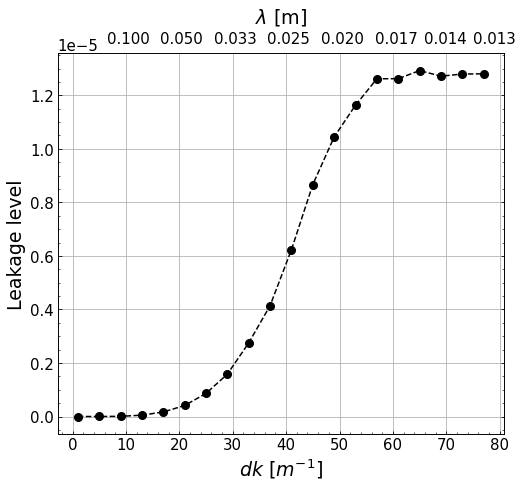

In [13]:
fig = plt.figure(figsize=(8,7))

ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
ax2.set_xticks([])
ax1.plot(dk,leak,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$dk$ [$m^{-1}$]', fontsize=19)
ax1.grid()

ax2.xaxis.set_label_coords(.5, 1.08)
ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
plt.text(0.11, leak.max()*1.08, '0.100')
plt.text(0.23, leak.max()*1.08, '0.050')
plt.text(0.35, leak.max()*1.08, '0.033')
plt.text(0.47, leak.max()*1.08, '0.025')
plt.text(0.59, leak.max()*1.08, '0.020')
plt.text(0.71, leak.max()*1.08, '0.017')
plt.text(0.82, leak.max()*1.08, '0.014')
plt.text(0.93, leak.max()*1.08, '0.013')


## Fix RMS level in real space

Vary the inner radius $k_{in}$ and keep $dk$ constant

In [14]:
# initialize parameters
N_screen = 2048 # this has to be large enough to incorporate the largest k_in
N_theta = 1024
D = 15.0
sigma = 1.0
maxdeg = 5.0
trunc = 'y'
option ='amp' # or 'phase'

RMS_want = 0.01 # input the desired RMS level
#k_in = np.arange(5,30,5) test
k_in = np.arange(1,72,2)
amp = 0.1 # the scaling factor of an error mask. May vary depending on the choice of RMS_want since we want it to roughly match the scaling factor corresponding to RMS_want
dk = 2 # width of the annular filter 
leak = np.zeros(len(k_in))  # leakage
noise_norm = np.zeros_like(leak) # initialize leakage level
#k_in = np.arange(0,screen1['kx'].max()-2,2)
k_out = k_in+dk
RMS = np.array([]) # initialize RMS of error maps used for generating the Appendix figure
RMS_sq = np.array([])
RMS_test = np.array([]) # initialize RMS of error maps used for actual calculation of leakage (they should be held at a constant level with super tiny variation)

### define functions
def linear(x, k, b):
    return(k*x+b)
def sqrt(x, k, b, c):
    """square root fit to the RMS vs. k_in"""
    return(k*np.sqrt(x+c)+b)

"""
line 34 to 70: generate error masks with different k_in and measure RMS of each. Then do a square root fit to RMS vs. k_in, which will be used later to hold RMS constant. 
"""

### create multiple error maps with varying k_in, and measure RMS of map.
screen1 = {}
screen1['N'] = N_screen
screen1['D'] = D
Initialize(screen1)
center = (screen1['D']/2, screen1['D']/2)
MultByGaussian(screen1, center, sigma)
if trunc=='y':
    InCircle(screen1, center, 2.5)
for i in range(len(k_in)):
    if option=='phase':
        emap_E = filter_annulus_phase(screen1, amp, k_in[i], k_out[i]) ### scaled error map in real space and unscaled error in k space
    elif option=='amp':
        emap_E = filter_annulus_amp(screen1, amp, k_in[i], k_out[i])
    rms_sq = np.abs(rms(emap_E)**2) #rms square
    RMS_sq = np.append(RMS_sq, rms_sq)
    rms_nosq = rms(emap_E) # rms
    RMS = np.append(RMS, rms_nosq)

### fit RMS vs. k_in
(fit1, err1) = opt.curve_fit(linear, k_in, RMS_sq, absolute_sigma=True) #rms square: fit a line
(fit2, err2) = opt.curve_fit(sqrt, k_in, RMS, absolute_sigma=True) # rms: fit sqrt
scaling = RMS_want * (amp/sqrt(k_in, fit2[0], fit2[1], fit2[2]))
sp = interp.InterpolatedUnivariateSpline(k_in, sqrt(k_in, fit2[0], fit2[1], fit2[2])) # spline for the RMS error
sp_scale = interp.InterpolatedUnivariateSpline(k_in, scaling) # spline for the scaling factor
### plot RMS, RMS^2 vs. k_in and fits
# fig = plt.figure(figsize=(14,5))
# plt.subplot(1,2,1)
# plt.plot(k_in, RMS, 'o', ms=5, color='black', label='data')
# plt.plot(k_in, sqrt(k_in, fit2[0], fit2[1], fit2[2]), label='fit')
# plt.xlabel(r'$k_{in}$')
# plt.ylabel('RMS in real space')
# plt.subplot(1,2,2)
# plt.plot(k_in, RMS_sq, 'o', ms=5, color='black', label='data')
# plt.plot(k_in, linear(k_in, fit1[0], fit1[1]), label='fit')
# plt.xlabel(r'$k_{in}$')
# plt.ylabel(r'$RMS^2$')

"""
line 80 to 170: 
    Repeat the leakage calculation
    generate an unperturbed screen and a perturbed one. 
    The RMS level of the error mask used to perturbed the screen is kept constant using the sqrt fit derived above and scaling the error mask factors.
    Then the leakage level is found as a function of k_in.
"""

# unperturbed perfect gaussian create E screen [m]
screen = {}
screen['N'] = N_screen
screen['D'] = D
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, sigma)
if trunc=='y':
    InCircle(screen, center, 2.5)
ScreenFFT(screen)

# interpolation in sky intensity [rad] (unperturbed beam)
lam = 0.002 #mm wavelength
thetamaxdeg = maxdeg
thetamax = thetamaxdeg*np.pi/180. # in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam)   # unperturbed
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in ell space
theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

for i in range(len(k_in)):
    kin = k_in[i]
    #kin = 5
    kout = kin + dk

    print('error map scaling =', sp_scale(kin), 'k_in =', kin, 'k_out =', kout)
    
    # perturbed E screen
    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    MultByGaussian(screen1, center, sigma)
    if trunc=='y':
        InCircle(screen1, center, 2.5)

    if option=='phase':
        emap_E = filter_annulus_phase(screen1, sp_scale(kin), kin, kout)
    elif option=='amp':
        emap_E = filter_annulus_amp(screen1, sp_scale(kin), kin, kout)
    else: print('Choose phase or amplitude errors')
    rms_test = rms(emap_E)
    RMS_test = np.append(RMS_test, rms_test) # check if RMS is kept constant
    ScreenFFT(screen1)

    # interpolate the perturbed beam 
    theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
    II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
    II1 = II1 * (np.sum(II0)/np.sum(II1)) ## normalize the perturbed beam 
    # shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
    theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

    # FT of sky intensity
    I_diff = II1 - II0 # take the difference in theta space (sky)
    fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
    fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space

    # average (FT of II0)^2 radially 
    bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
    l_flatten = l.flatten()
    fft_numerical0 = fft_I0.flatten()
    #fft_numerical1 = fft_I1.flatten()
    fft_numerical_diff = fft_Idiff.flatten()
    bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
    #bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
    bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
    l_vec = bin_edges[0:-1] # ell 1D vector

    beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
    #error[i] = np.mean(beam_diff_rela[1:3]) ## maxdeg=3.0
    #error[i] = np.mean(beam_diff_rela[4]) ## maxdeg=10.0
    leak[i] = np.mean(beam_diff_rela[(l_vec>=50)&(l_vec<=250)])**2 # average the beam difference over 50<l<250
    print('leakage = {}'.format(leak[i]))

    # Calculates the noise level in fourier space (V^2/Hz)
    emap_fft = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(emap_E))) # scaled error map in fourier space
    norm_fft = np.abs(emap_fft**2)/screen1['dk']**2/screen1['N']**4 # V^2/Hz^2
    idx = np.where((screen1['kap']<kout) & (screen1['kap']>kin)) # inside the filter
    avg_fft = np.mean(norm_fft[idx]) # V^2/Hz^2
    total_Vf = np.sum(norm_fft)*screen1['dk']**2
    rms_sq = np.abs(rms(emap_E)**2)
#     print('V^2/Hz^2 = ',total_Vf)
#     print('RMS^2 = ', rms_sq)
    noise_norm[i] = avg_fft
    
print('Done')

<ipython-input-14-32550247d068>:28: RuntimeWarning: invalid value encountered in sqrt
  return(k*np.sqrt(x+c)+b)


error map scaling = 0.2989446974659514 k_in = 1 k_out = 3
leakage = 1.716181310725119e-10
error map scaling = 0.18396988978487464 k_in = 3 k_out = 5
leakage = 8.005801009480138e-10
error map scaling = 0.14939740390766576 k_in = 5 k_out = 7
leakage = 2.069884067044795e-09
error map scaling = 0.13010933933845986 k_in = 7 k_out = 9
leakage = 6.516944381045616e-09
error map scaling = 0.11720407989968397 k_in = 9 k_out = 11
leakage = 7.851541904588876e-09
error map scaling = 0.10772933232762517 k_in = 11 k_out = 13
leakage = 8.401345887270739e-09
error map scaling = 0.10036413576471472 k_in = 13 k_out = 15
leakage = 8.333986356414304e-09
error map scaling = 0.0944115367582799 k_in = 15 k_out = 17
leakage = 7.202581677408903e-09
error map scaling = 0.08946248305728124 k_in = 17 k_out = 19
leakage = 7.560440298857535e-09
error map scaling = 0.08525816246294285 k_in = 19 k_out = 21
leakage = 8.222682670261396e-09
error map scaling = 0.08162537570875683 k_in = 21 k_out = 23
leakage = 8.49993401

Text(0.91, 9.9493658881908e-09, '0.014')

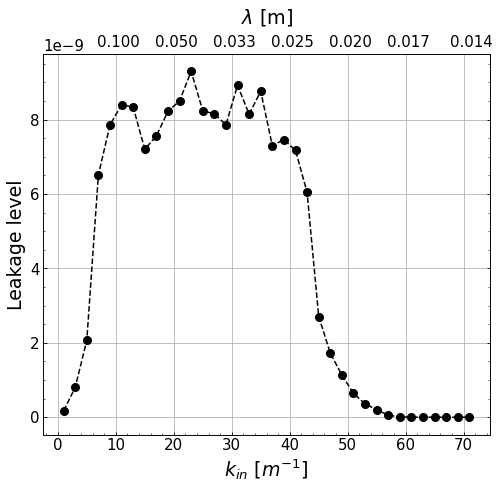

In [15]:
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twiny()
ax2.set_xticks([])
ax1.plot(k_in,leak,'o--', ms=8, color='black')
ax1.set_ylabel('Leakage level', fontsize=19)
ax1.set_xlabel(r'$k_{in}$ [$m^{-1}$]', fontsize=19)
ax1.grid()
#plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#xlabel = [1.000, 0.083, 0.042, 0.027, 0.020, 0.016]
#ax2.xaxis.set_major_locator(mpl.ticker.FixedLocator(xlabel))
ax2.xaxis.set_label_coords(.5, 1.08)
ax2.set_xlabel('$\lambda$ [m]', fontsize=19)
plt.text(0.12, leak.max()*1.07, '0.100')
plt.text(0.25, leak.max()*1.07, '0.050')
plt.text(0.38, leak.max()*1.07, '0.033')
plt.text(0.51, leak.max()*1.07, '0.025')
plt.text(0.64, leak.max()*1.07, '0.020')
plt.text(0.77, leak.max()*1.07, '0.017')
plt.text(0.91, leak.max()*1.07, '0.014')

# Justify the circular truncation radius

diffraction pattern (Airy disk) becomes significant when the truncation radius is smaller than or comparable to the Gaussian $\sigma$. 

In [16]:
# try different truncation radii

screen = {}
screen['N'] = 2048
screen['D'] = 15
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
InCircle(screen, center, 2.0)
ScreenFFT(screen)
lam = 0.002
thetamaxdeg = 3.0
thetamax = thetamaxdeg*np.pi/180. 
theta_vec = np.linspace(-thetamax,thetamax,1024) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 

screen1 = {}
screen1['N'] = 2048
screen1['D'] = 15
Initialize(screen1)
center = (screen1['D']/2, screen1['D']/2)
MultByGaussian(screen1, center, 1.0)
InCircle(screen1, center, 1.0)
ScreenFFT(screen1)
II1 = Project_I_on_thetagrid(theta_vec,screen1,lam) 

screen2 = {}
screen2['N'] = 2048
screen2['D'] = 15
Initialize(screen2)
center = (screen2['D']/2, screen2['D']/2)
MultByGaussian(screen2, center, 1.0)
InCircle(screen2, center, 0.4)
ScreenFFT(screen2)
II2 = Project_I_on_thetagrid(theta_vec,screen2,lam) 


Text(0.5, 1.0, 'Trunc_radius = 0.4 m')

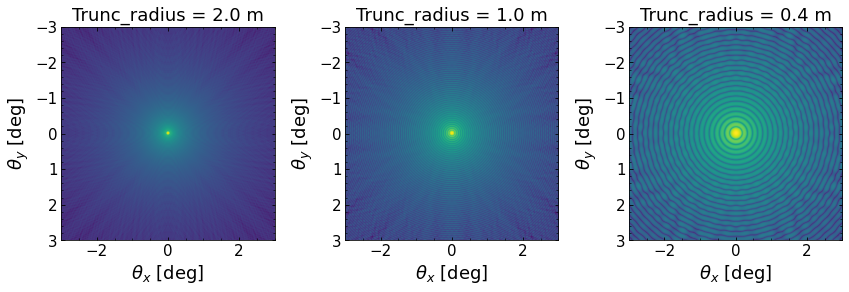

In [17]:
fig = plt.figure(figsize=(14,4))
plt.subplots_adjust(wspace=0.33)
plt.subplot(1,3,1)
plt.imshow(np.log10(II0), extent=(-thetamaxdeg, thetamaxdeg, thetamaxdeg, -thetamaxdeg))
plt.xlabel(r'$\theta_x$ [deg]',fontsize=18)
plt.ylabel(r'$\theta_y$ [deg]',fontsize=18)
plt.title('Trunc_radius = 2.0 m')
plt.subplot(1,3,2)
plt.imshow(np.log10(II1), extent=(-thetamaxdeg, thetamaxdeg, thetamaxdeg, -thetamaxdeg))
plt.xlabel(r'$\theta_x$ [deg]',fontsize=18)
plt.ylabel(r'$\theta_y$ [deg]',fontsize=18)
plt.title('Trunc_radius = 1.0 m')
plt.subplot(1,3,3)
plt.imshow(np.log10(II2), extent=(-thetamaxdeg, thetamaxdeg, thetamaxdeg, -thetamaxdeg))
plt.xlabel(r'$\theta_x$ [deg]',fontsize=18)
plt.ylabel(r'$\theta_y$ [deg]',fontsize=18)
plt.title('Trunc_radius = 0.4 m')

# Gaussian $\sigma$ comparison - 0.5, 1.0, 2.0 m

In [37]:
N_screen = 2048 # 8192 for figures in the paper; this only changes the leakage amplitude, irrelevant to the pattern we're studying 
N_theta = 1024  # 1024
D = 15.0
sigma = [0.5, 1.0, 2.0]
thetamaxdeg = 3.0 # interpolate from -5 deg to +5 deg 

option = 'amp' # 'phase' ### amplitude or phase perturbation 
A = 1.0 # scaling factor of the error mask 
kin = 15
kout = kin+10


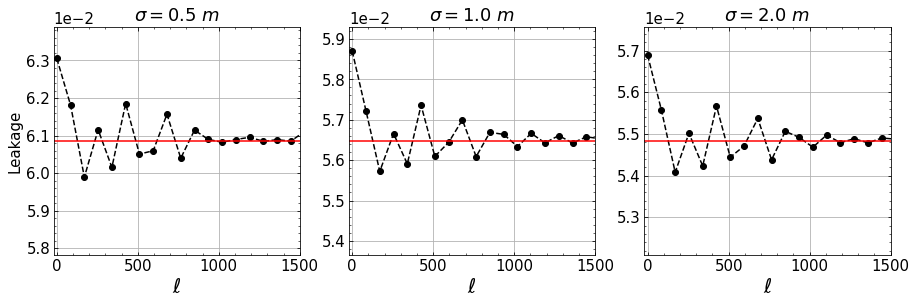

In [38]:
fig = plt.figure(figsize=(15, 4.2))

for i in range(len(sigma)):
    # unperturbed 
    screen = {}
    screen['N'] = N_screen
    screen['D'] = D
    Initialize(screen)
    center = (screen['D']/2, screen['D']/2)
    MultByGaussian(screen, center, sigma[i]) # Gaussian E-field
    InCircle(screen, center, 2.5) # circular truncation
    ScreenFFT(screen) # take FT of the screen

    lam = 0.002 #m wavelength
    thetamax = thetamaxdeg*np.pi/180. # degree to radian
    theta_vec = np.linspace(-thetamax,thetamax,N_theta)  
    II0 = Project_I_on_thetagrid(theta_vec,screen,lam) # interpolation

    fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in 1/rad (l) space

    #calculate l
    theta_vec = np.linspace(0, 2*thetamax, N_theta) # shift coordinates, easy to convert to l
    n = theta_vec.shape[0]
    dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
    l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
    (l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
    l = np.sqrt(l_x**2 + l_y**2)

    screen1 = {}
    screen1['N'] = N_screen
    screen1['D'] = D
    Initialize(screen1)
    center = (screen1['D']/2, screen1['D']/2)
    MultByGaussian(screen1, center, sigma[i])
    InCircle(screen1, center, 2.5)

    if option=='phase':
        emap_E = filter_annulus_phase(screen1, A, kin, kout)
    elif option=='amp':
        emap_E = filter_annulus_amp(screen1, A, kin, kout)

    # interpolate the perturbed beam 
    ScreenFFT(screen1)
    theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
    II1 = Project_I_on_thetagrid(theta_vec, screen1, lam) # perturbed
    II1 = II1 * (np.sum(II0)/np.sum(II1)) # normalize the perturbed beam --> matching powers
    # shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
    theta_vec = np.linspace(0,2*thetamax,N_theta) #rad

    # FT of sky intensity
    I_diff = II0 - II1 # take the difference in theta space (sky)
    fft_Idiff = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(I_diff)))) # FFT the difference to ell space
    fft_I1 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))) # in ell space

    # average (FT of II0)^2 radially 
    bin_edges = np.linspace(0,l.max(),int(len(theta_vec)/2))
    l_flatten = l.flatten()
    fft_numerical0 = fft_I0.flatten()
    fft_numerical1 = fft_I1.flatten()
    fft_numerical_diff = fft_Idiff.flatten()
    bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical0, statistic='mean', bins=bin_edges) 
    bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical1, statistic='mean', bins=bin_edges) # bin_mean is the binned numerical beam
    bin_mean_diff, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical_diff, statistic='mean', bins=bin_edges) # bin the beam difference
    l_vec = bin_edges[0:-1] # ell 1D vector

    beam_diff_rela = bin_mean_diff/bin_mean0 # relative beam difference
    #error = np.mean(beam_diff_rela[1:3]) #for maxdeg=3.0
    error = np.mean(beam_diff_rela[(l_vec>=49)&(l_vec<=251)]) # average the beam difference between 0<l<500

    plt.subplot(1,3,i+1)
    plt.plot(l_vec, beam_diff_rela,'o--', color='black', label='Fractional difference') #sigma=0.5m
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-2))
    plt.xlabel(r'$\ell$', fontsize=20)
    plt.axhline(error, color='red')
    plt.xlim(-20,1500)
    plt.ylim(error*0.95, error*1.05)
    if i==0:
        plt.ylabel('Leakage')
    plt.title(r'$\sigma={}~m$'.format(sigma[i]))
    plt.grid()
    
#plt.savefig('Figures/Gaussian_sig.png', bbox_inches='tight', dpi=600)